## Import Libraries

In [5]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')


## Load and Inspect the Data

In [8]:
# Load your dataset
df = pd.read_csv('parkinsons.csv')  # Replace with your file name

# Check shape and info
print(df.shape)
print(df.info())

# Check class distribution
print(df['status'].value_counts())  # Assuming 'status' is the target column


(195, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    

## Data Pre-processing

In [11]:
# Rename columns to clean names (replace special characters)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Show updated column names
print(df.columns.tolist())


['name', 'MDVP_Fo_Hz_', 'MDVP_Fhi_Hz_', 'MDVP_Flo_Hz_', 'MDVP_Jitter_', 'MDVP_Jitter_Abs_', 'MDVP_RAP', 'MDVP_PPQ', 'Jitter_DDP', 'MDVP_Shimmer', 'MDVP_Shimmer_dB_', 'Shimmer_APQ3', 'Shimmer_APQ5', 'MDVP_APQ', 'Shimmer_DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


In [13]:
# Drop the 'name' column
df = df.drop('name', axis=1)

In [15]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### Handling Missing Values

In [18]:
# Check data types and missing values (redundant but safe)
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
MDVP_Fo_Hz_         0
MDVP_Fhi_Hz_        0
MDVP_Flo_Hz_        0
MDVP_Jitter_        0
MDVP_Jitter_Abs_    0
MDVP_RAP            0
MDVP_PPQ            0
Jitter_DDP          0
MDVP_Shimmer        0
MDVP_Shimmer_dB_    0
Shimmer_APQ3        0
Shimmer_APQ5        0
MDVP_APQ            0
Shimmer_DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


## Exploratory Data Analysis (EDA)

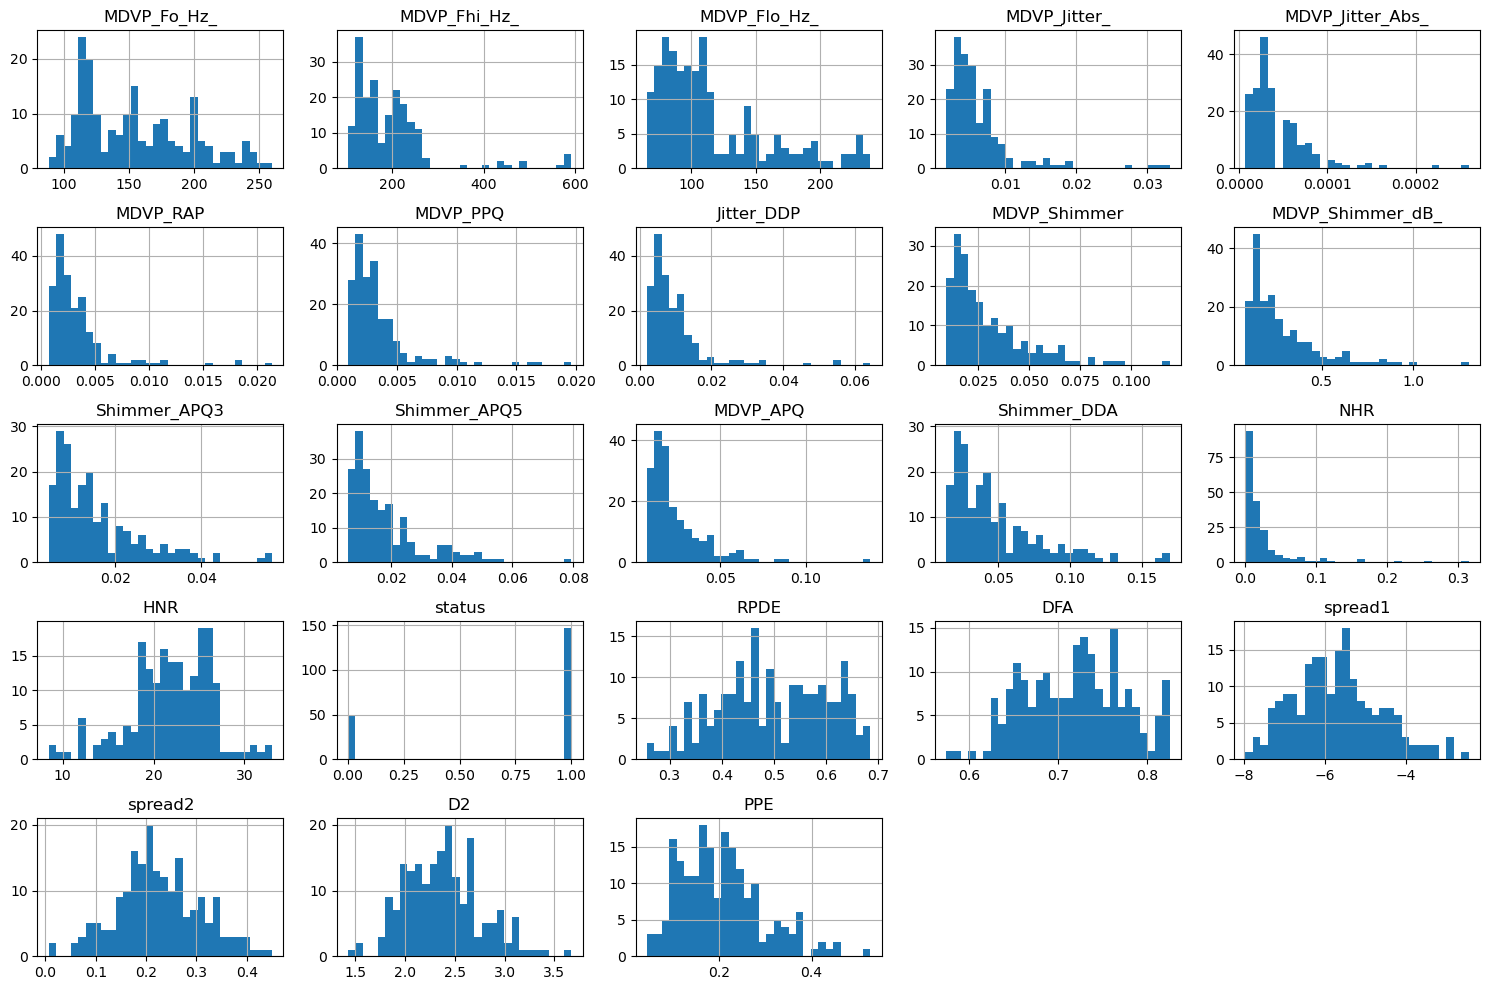

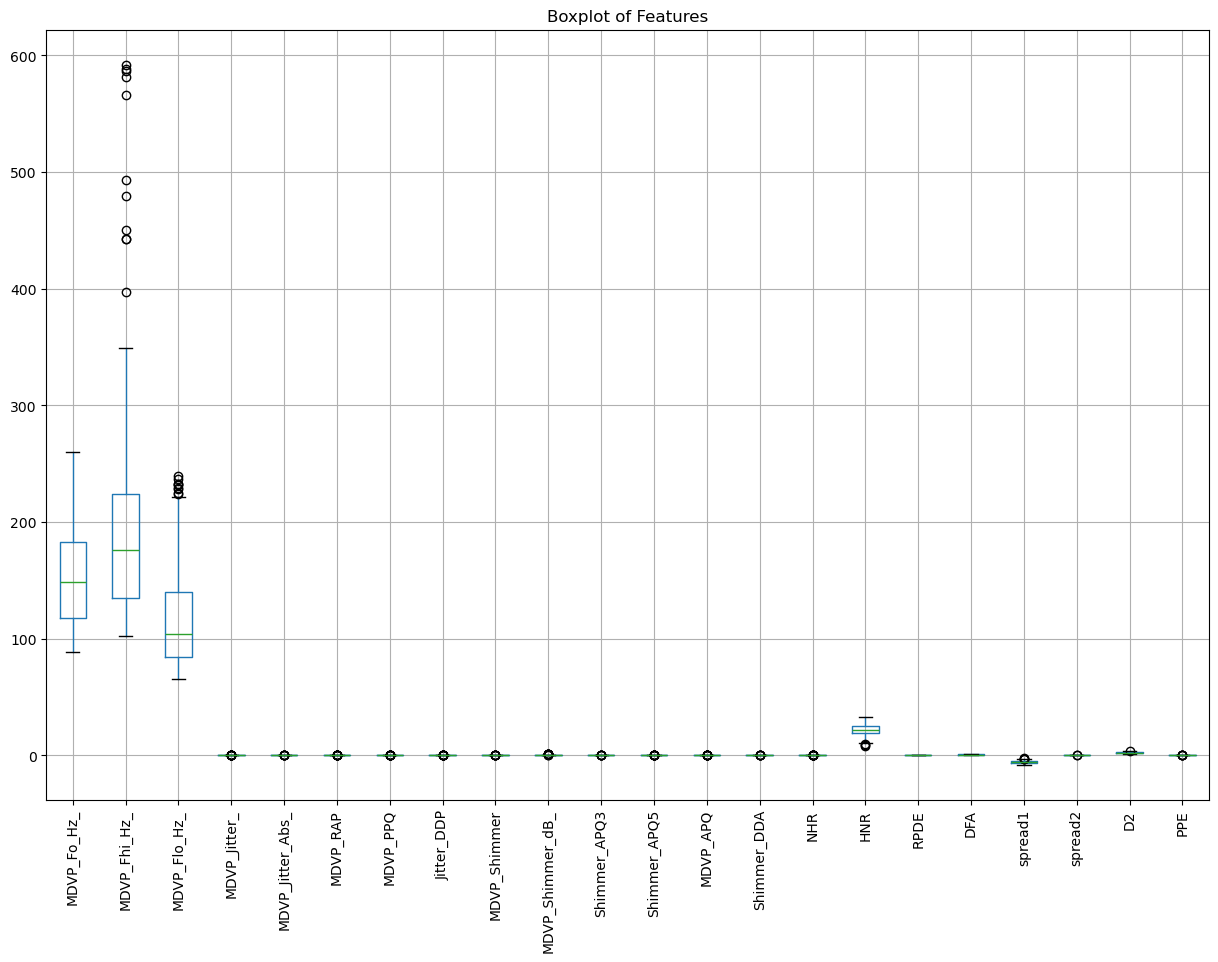

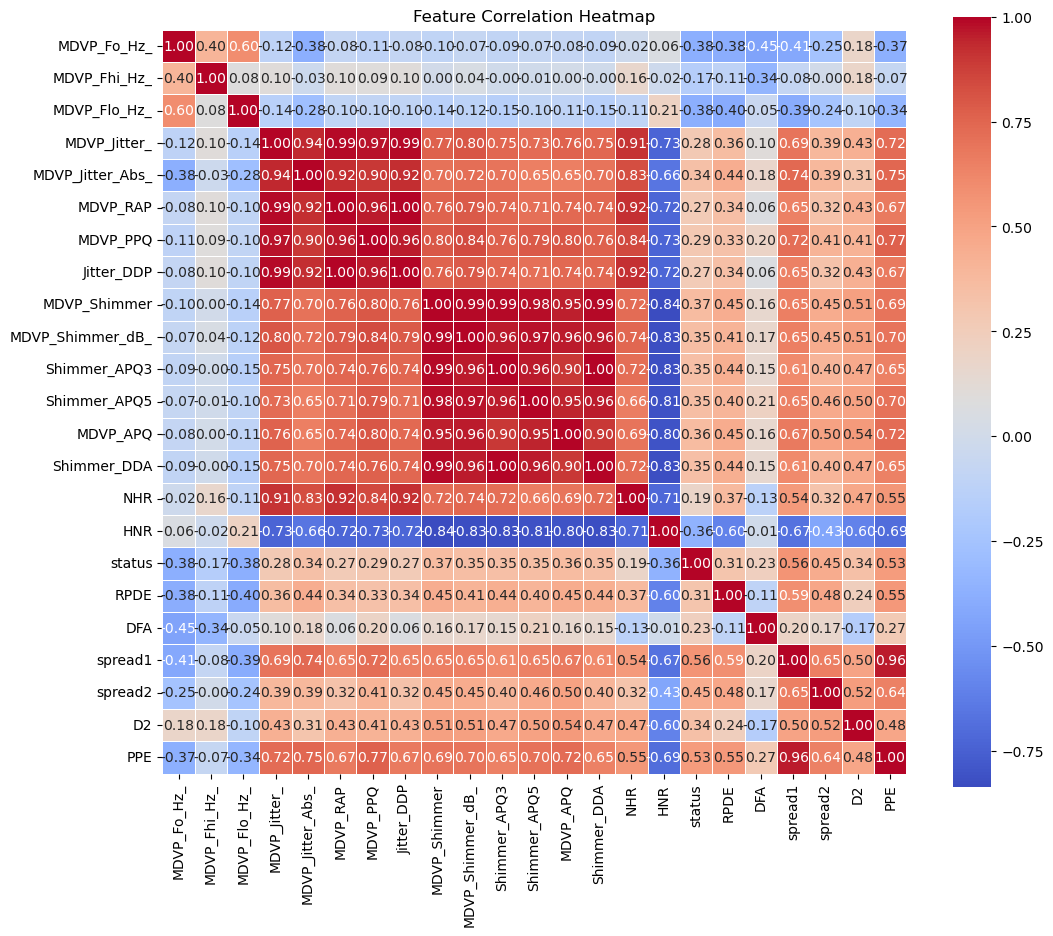

In [22]:
# Histograms
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.savefig("Histogram.png", dpi = 300)
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(15, 10))
df.drop('status', axis=1).boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot of Features")
plt.show()

# Correlation heatmap with coefficients inside each square
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.5, linecolor='white', annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap")
plt.savefig("heatmap.png", dpi = 300)
plt.show()


In [26]:
X = df.drop('status', axis=1)
y = df['status']

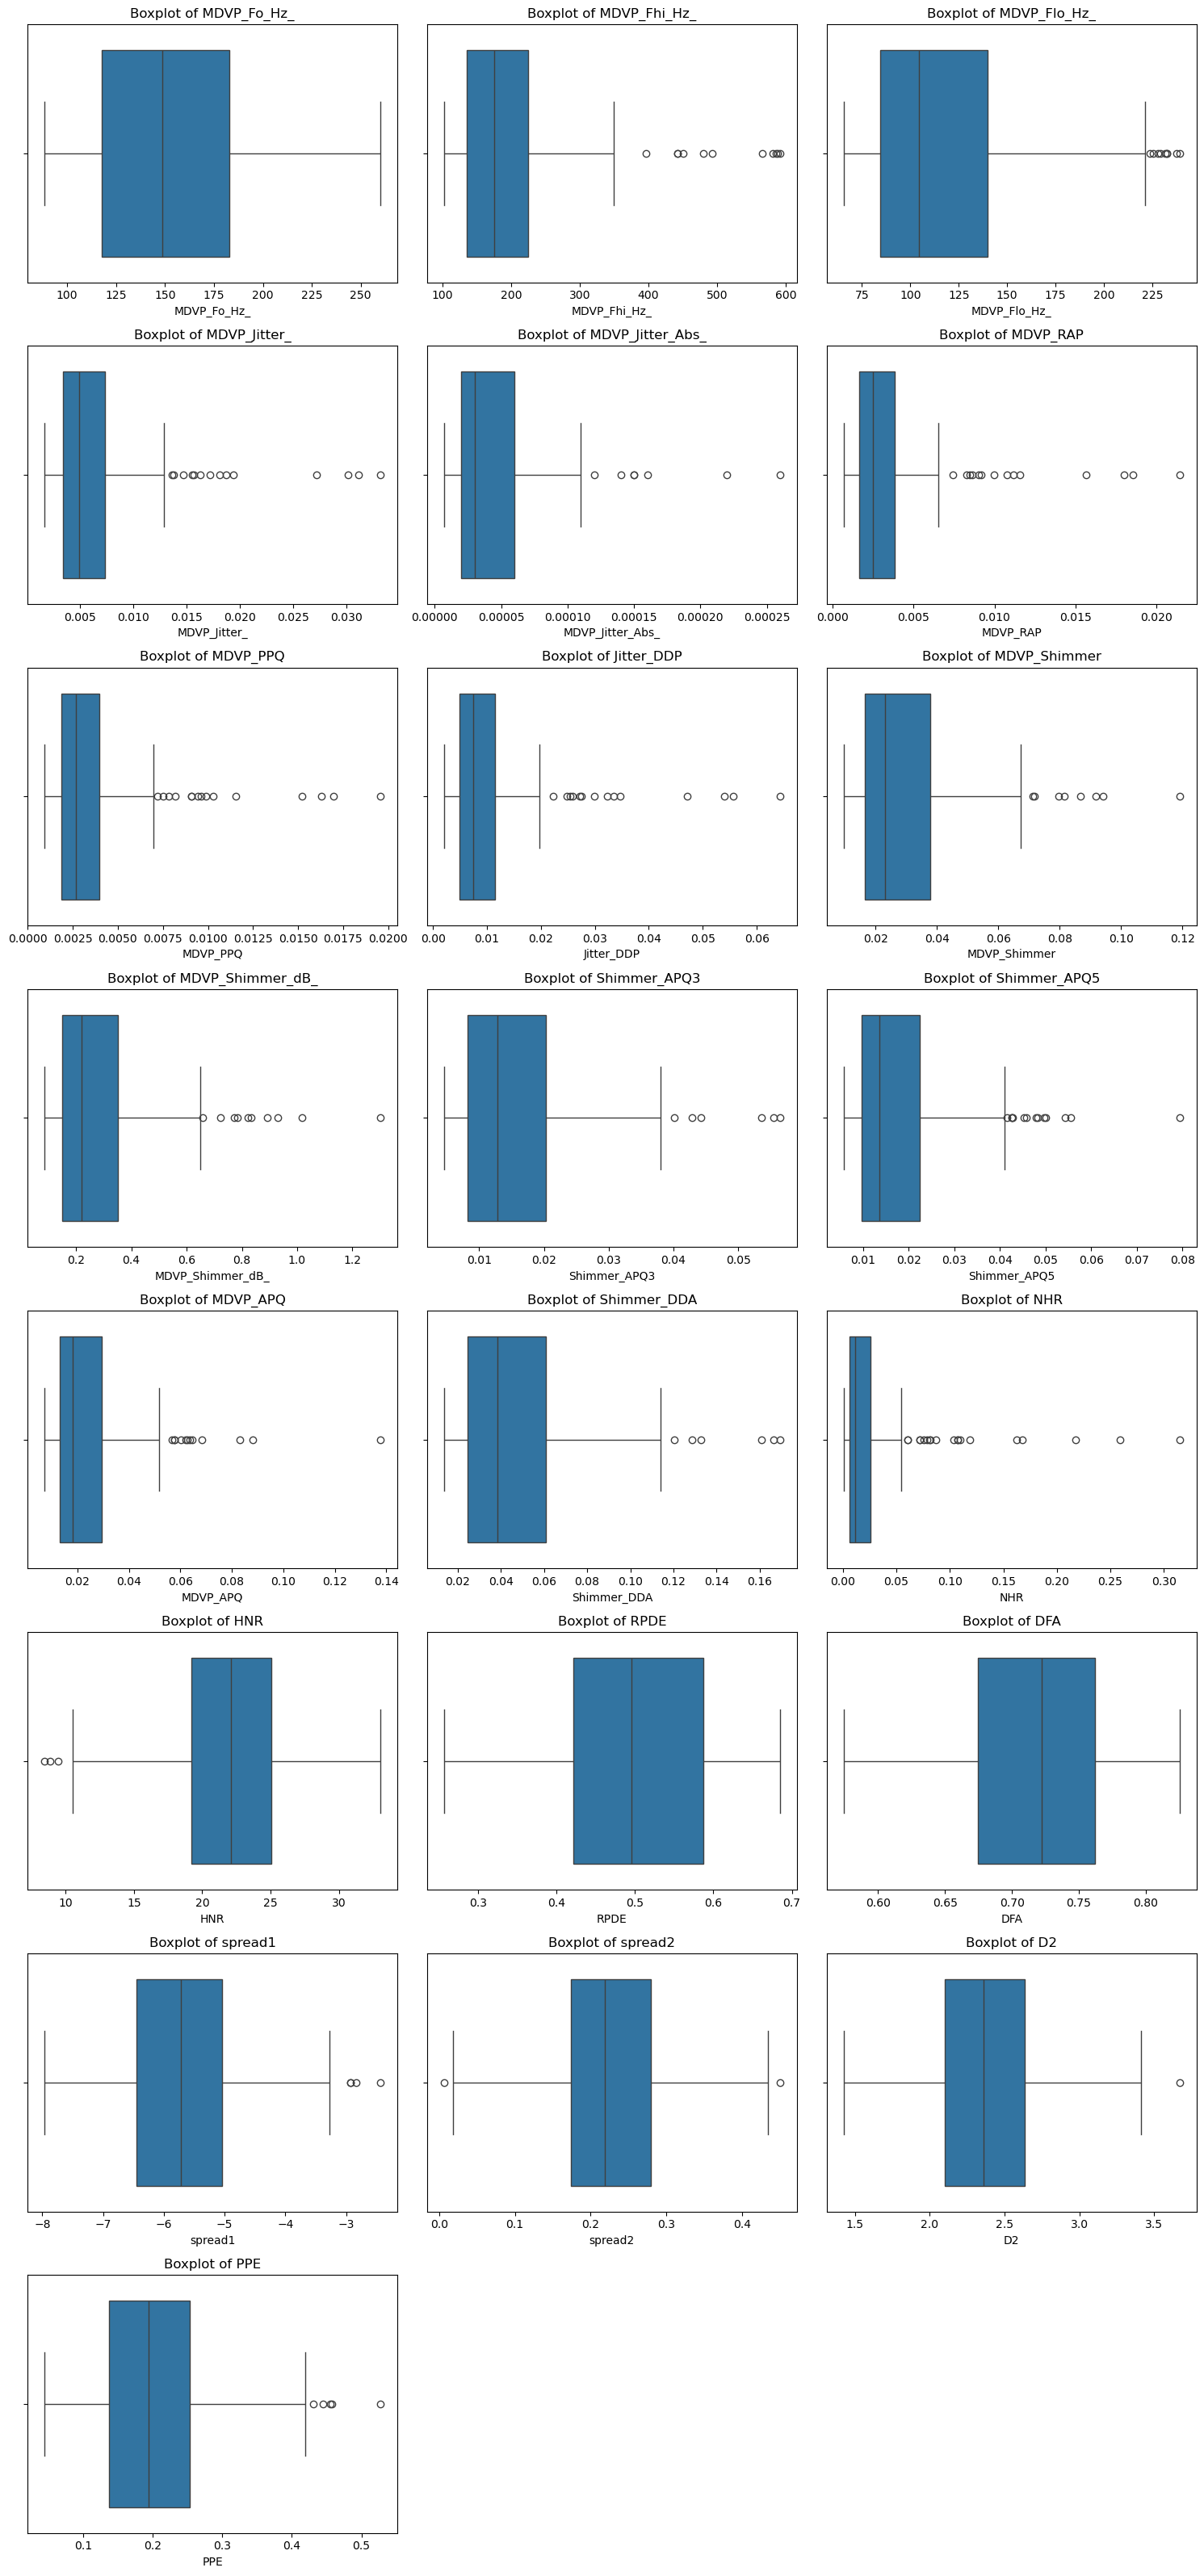

In [30]:
# Number of features
num_cols = X.select_dtypes(include=np.number).columns
n = len(num_cols)

# Grid size (adjust as needed)
cols = 3
rows = int(np.ceil(n / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # flatten in case of 2D array

# Plot boxplots
for i, col in enumerate(num_cols):
    sns.boxplot(x=X[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    
# Turn off any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('boxplots.png', dpi = 300)
plt.show()


### Detecting Outliers using IQR method

In [34]:
import numpy as np

def detect_outliers_iqr(data):
    outliers_indices = []
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_condition = (data[col] < lower_bound) | (data[col] > upper_bound)
        outliers_indices.extend(data[outlier_condition].index.tolist())
    return list(set(outliers_indices))

outliers = detect_outliers_iqr(X)
print(f'Number of detected outliers: {len(outliers)}')


Number of detected outliers: 47


In [38]:
def winsorize_series(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return s.clip(lower=lower_bound, upper=upper_bound)

X_winsorized = X.copy()
for col in X.columns:
    if np.issubdtype(X[col].dtype, np.number):
        X_winsorized[col] = winsorize_series(X[col])

print("Outliers capped using winsorization.")
print(X_winsorized.shape)


Outliers capped using winsorization.
(195, 22)


#### Boxplots after handling outliers

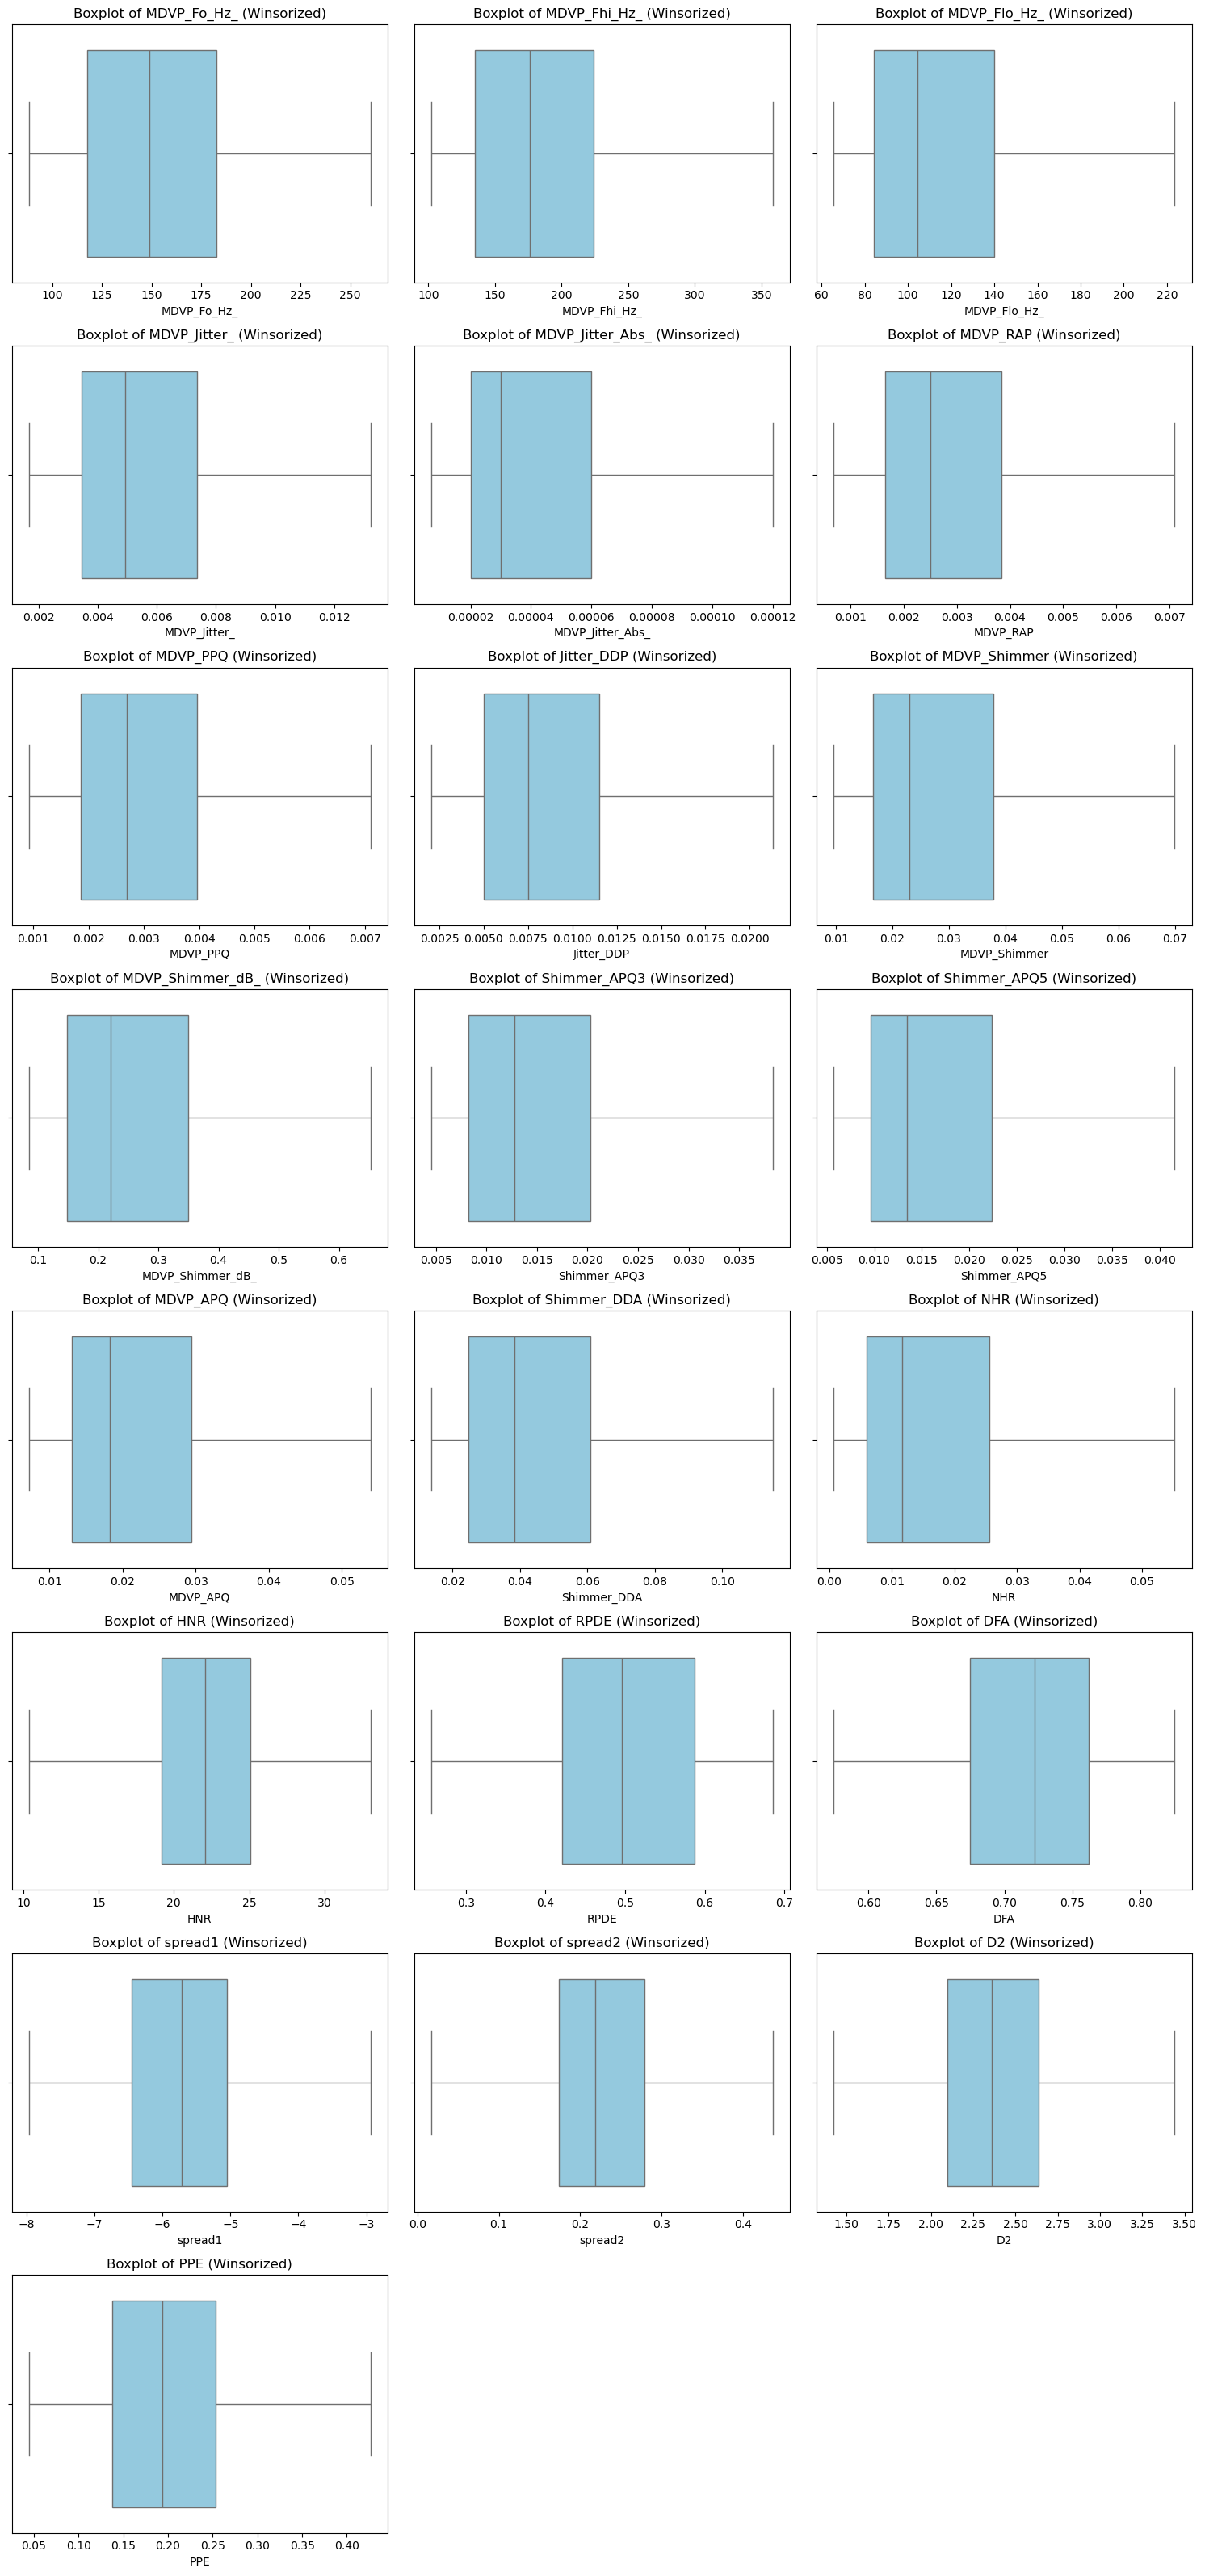

In [43]:
# Select only numeric columns
num_cols = X_winsorized.select_dtypes(include=np.number).columns
n = len(num_cols)

# Define subplot grid size
cols = 3
rows = int(np.ceil(n / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Plot boxplots of winsorized data
for i, col in enumerate(num_cols):
    sns.boxplot(x=X_winsorized[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col} (Winsorized)')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("boxplots after outliers.png", dpi = 300)
plt.show()


## Feature Scaling

In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_winsorized)


### Distribution of target variable

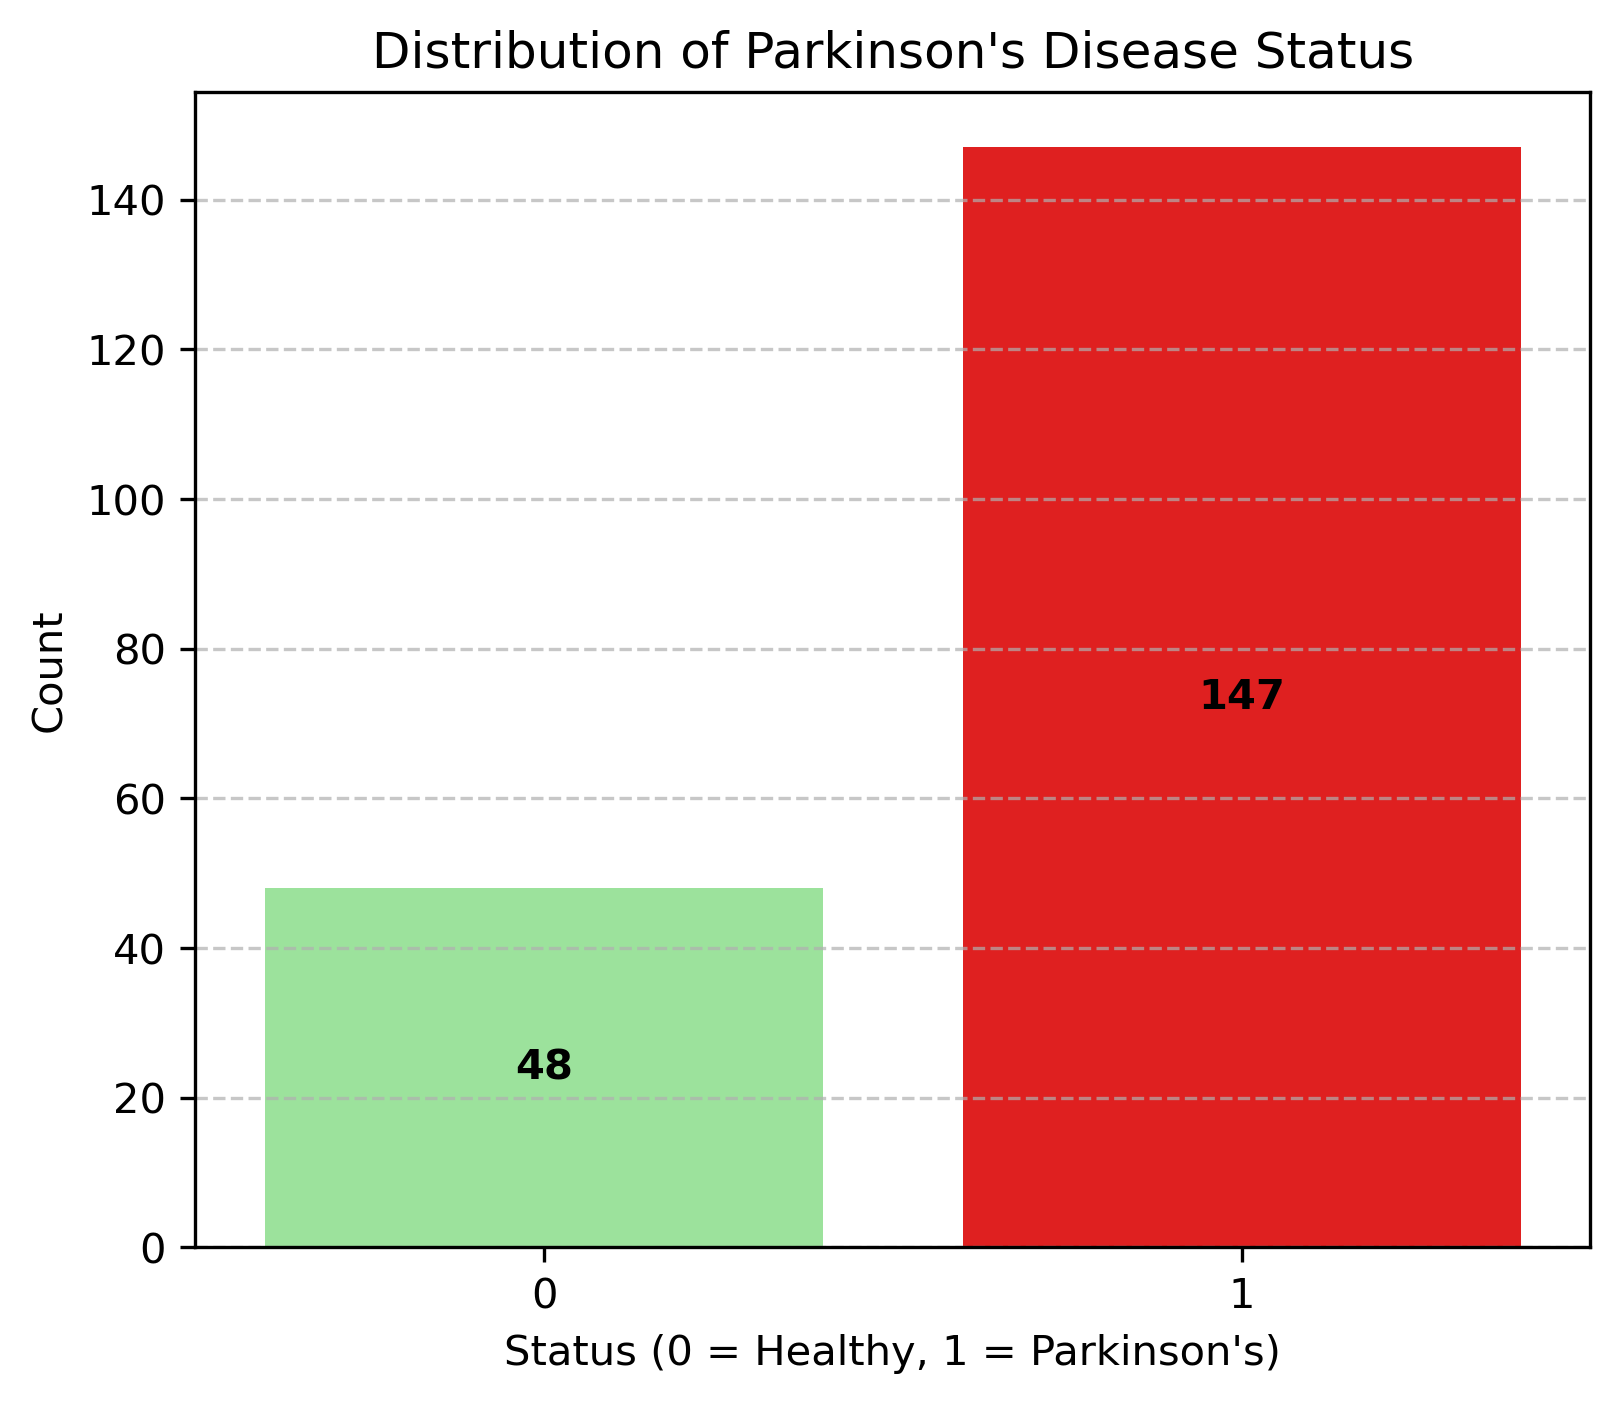

In [120]:

# Countplot of the target variable
plt.figure(figsize=(6, 5), dpi=300)  # High resolution (for print/posters)
color = ['lightgreen', 'red']
ax = sns.countplot(x='status', data=df, palette=color)

# Add the count value inside each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2,  # inside the bar (vertically centered)
            str(count), ha='center', va='center', fontsize=10, color='black', fontweight='bold')

plt.title('Distribution of Parkinson\'s Disease Status')
plt.xlabel('Status (0 = Healthy, 1 = Parkinson\'s)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("distribution.png", dpi=300)
plt.show()


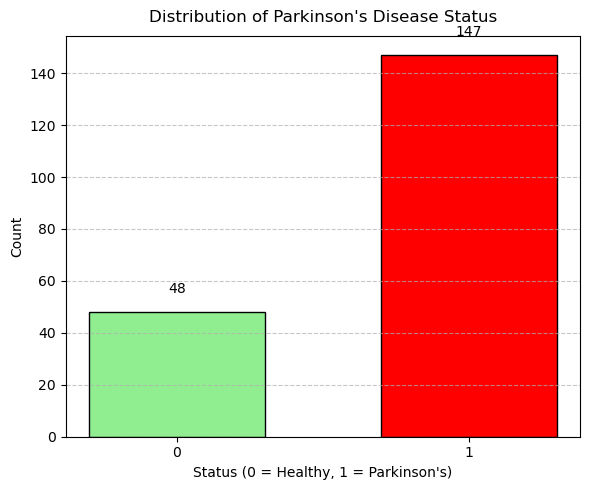

In [124]:
original_counts = pd.Series(y).value_counts().sort_index()
width = 0.6

# Create a standalone figure
plt.figure(figsize=(6, 5))

# Bar plot
plt.bar(original_counts.index.astype(str), original_counts, width, 
        color=['lightgreen', 'red'], edgecolor='black')

# Titles and labels
plt.title('Distribution of Parkinson\'s Disease Status', pad=10)
plt.xlabel('Status (0 = Healthy, 1 = Parkinson\'s)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels above bars
for class_label, count in original_counts.items():
    plt.text(class_label, count + max(original_counts)*0.05, 
             f'{count}', ha='center')

# Show plot
plt.tight_layout()
plt.savefig('barplots of target variable.png', dpi = 300)
plt.show()


### Handling Class Imbalance (SMOTE)

In [58]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())


status
1    147
0    147
Name: count, dtype: int64


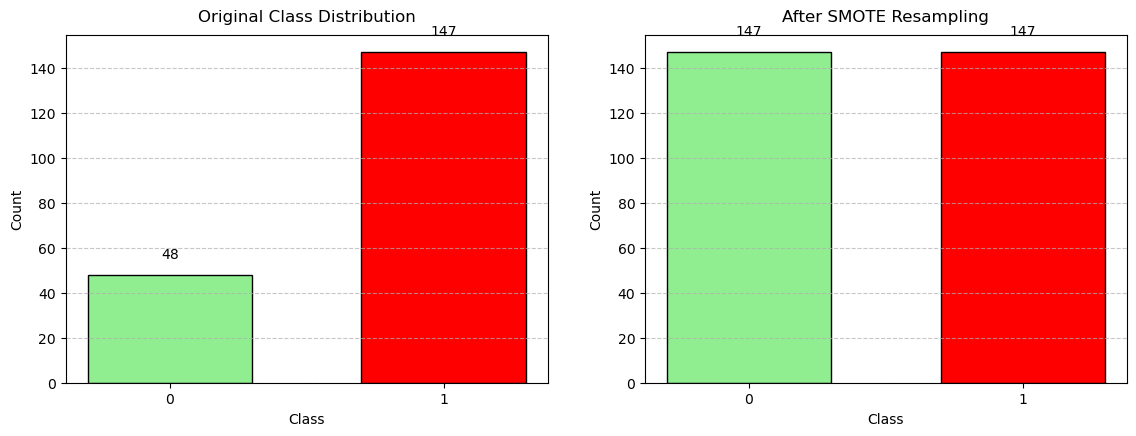

In [60]:
# Get class counts
original_counts = pd.Series(y).value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set width for bars
width = 0.6

# =====================================
# First subplot - Original distribution
# =====================================
ax1.bar(original_counts.index.astype(str), original_counts, width, 
        color=['lightgreen', 'red'], edgecolor='black')
ax1.set_title('Original Class Distribution', pad=10)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on original plot
for class_label, count in original_counts.items():
    ax1.text(class_label, count + max(original_counts)*0.05, 
             f'{count}', ha='center')

# =====================================
# Second subplot - After SMOTE
# =====================================
ax2.bar(resampled_counts.index.astype(str), resampled_counts, width, 
        color=['lightgreen', 'red'], edgecolor='black')
ax2.set_title('After SMOTE Resampling', pad=10)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on SMOTE plot
for class_label, count in resampled_counts.items():
    ax2.text(class_label, count + max(resampled_counts)*0.05, 
             f'{count}', ha='center')

# Adjust layout and show
plt.tight_layout(pad=3.0)
plt.savefig("after smote.png", dpi = 300)
plt.show()

## Feature Selection (Correlation + RFE)

In [66]:
# Remove highly correlated features
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
cor_matrix = X_resampled_df.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
X_filtered = X_resampled_df.drop(columns=to_drop)

# Recursive Feature Elimination (RFE)
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=15)
X_selected = rfe_selector.fit_transform(X_filtered, y_resampled)
selected_features = X_filtered.columns[rfe_selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['MDVP_Fo_Hz_', 'MDVP_Fhi_Hz_', 'MDVP_Flo_Hz_', 'MDVP_Jitter_',
       'MDVP_Shimmer', 'RPDE', 'DFA', 'spread2', 'D2'],
      dtype='object')


### Selected Features Plot

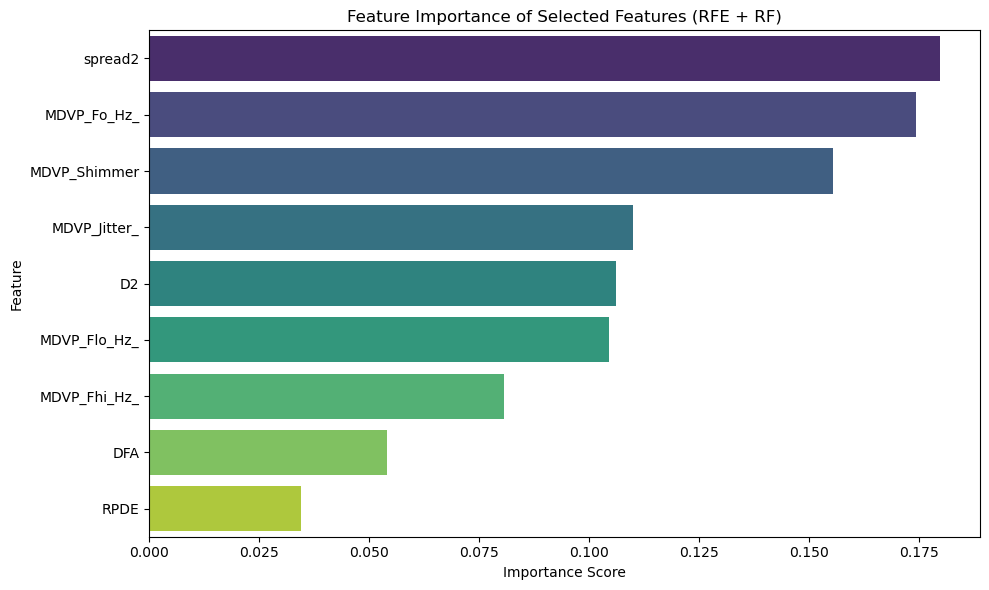

In [69]:
# Get feature importances from the fitted estimator
importances = rfe_selector.estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance of Selected Features (RFE + RF)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("feature importance.png", dpi = 300)
plt.show()


### Train-Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

## Model Training with 5-Fold Cross-Validation and GridSearchCV

#### SVM (Support Vector Machine)

In [76]:
# SVM hyperparameter tuning
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM Parameters:", grid_svm.best_params_)
print("Best SVM CV Accuracy:", grid_svm.best_score_)


Best SVM Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM CV Accuracy: 0.9276595744680851


#### Random Forest

In [79]:
# Random Forest hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Parameters:", grid_rf.best_params_)
print("Best RF CV Accuracy:", grid_rf.best_score_)


Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best RF CV Accuracy: 0.9574468085106383


#### XGBoost

In [82]:
# XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGB Parameters:", grid_xgb.best_params_)
print("Best XGB CV Accuracy:", grid_xgb.best_score_)

Best XGB Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best XGB CV Accuracy: 0.9617021276595745


## Evaluate Model Performance on Test Set

### Define Evaluation Function

In [88]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:")
    print(report)
    print(f"AUC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


### Evaluate All Models

--- SVM Evaluation ---
Accuracy: 1.0000
Confusion Matrix:


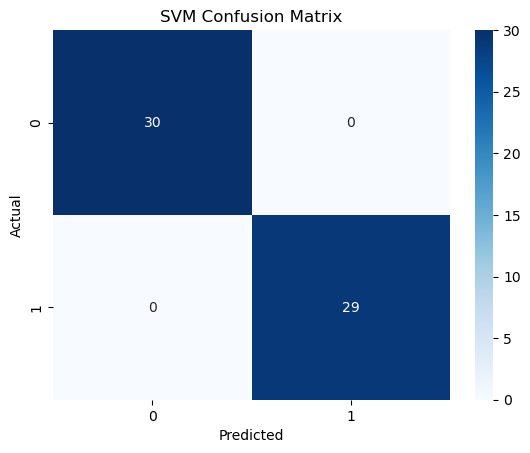

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

AUC Score: 1.0000


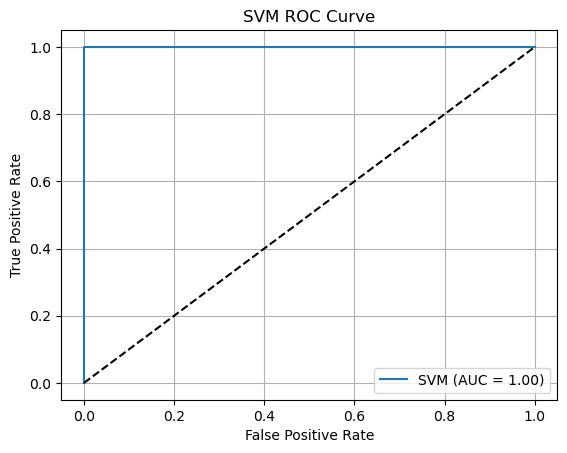

--- Random Forest Evaluation ---
Accuracy: 1.0000
Confusion Matrix:


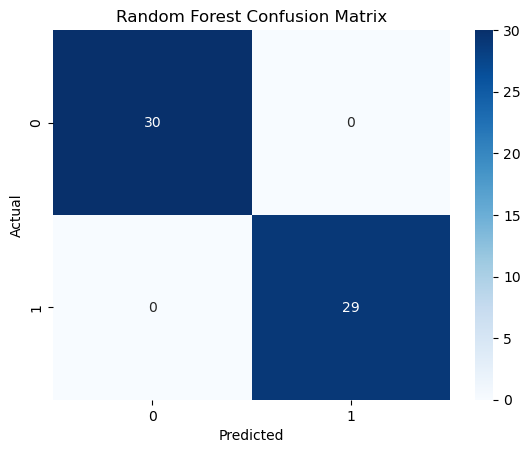

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

AUC Score: 1.0000


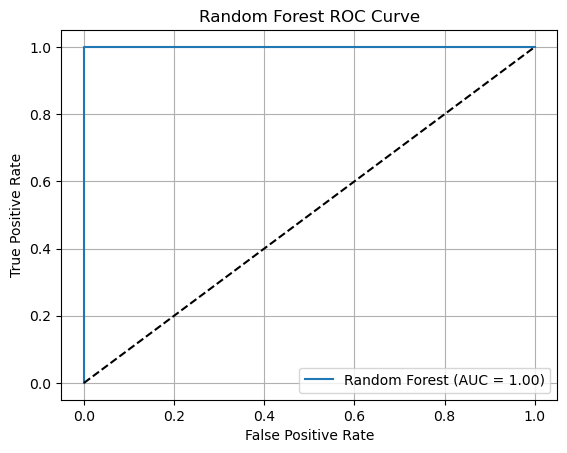

--- XGBoost Evaluation ---
Accuracy: 0.9661
Confusion Matrix:


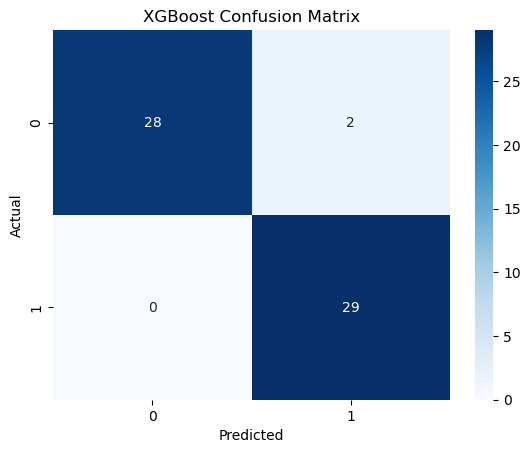

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        29

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

AUC Score: 0.9977


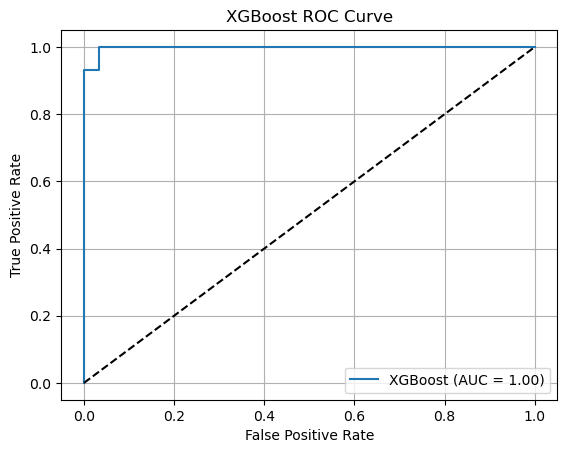

In [91]:
evaluate_model(grid_svm.best_estimator_, X_test, y_test, "SVM")
evaluate_model(grid_rf.best_estimator_, X_test, y_test, "Random Forest")
evaluate_model(grid_xgb.best_estimator_, X_test, y_test, "XGBoost")

### saving metrics

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import os

def evaluate_model(model, X_test, y_test, model_name, save_dir="model_evaluation"):
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    # Save metrics to Excel
    report_df = pd.DataFrame(report_dict).transpose()
    metrics_summary = pd.DataFrame({
        "Metric": ["Accuracy", "AUC"],
        "Value": [acc, auc]
    })

    with pd.ExcelWriter(os.path.join(save_dir, f"{model_name}_evaluation.xlsx")) as writer:
        metrics_summary.to_excel(writer, sheet_name="Summary", index=False)
        report_df.to_excel(writer, sheet_name="Classification Report")
        pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]).to_excel(writer, sheet_name="Confusion Matrix")

    # Save Confusion Matrix as Image
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name}_confusion_matrix.png"))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name}_roc_curve.png"))
    plt.show()


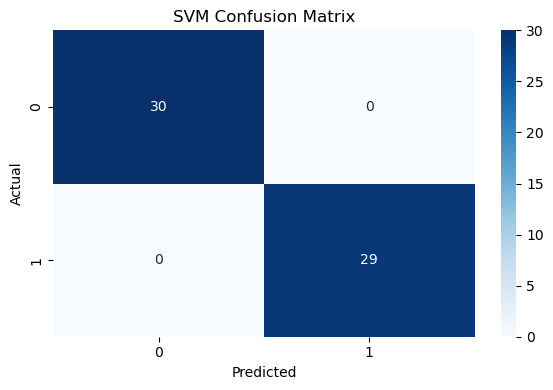

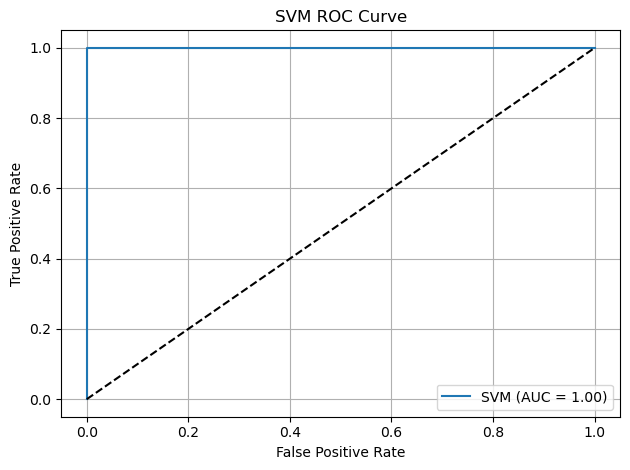

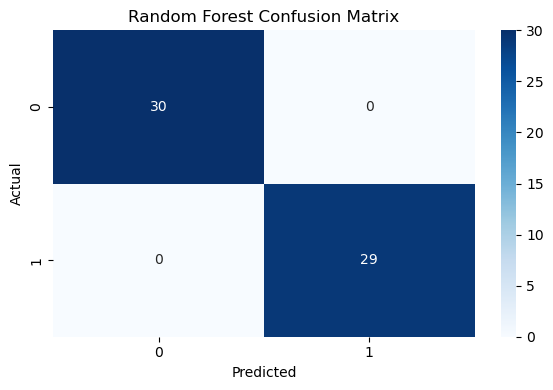

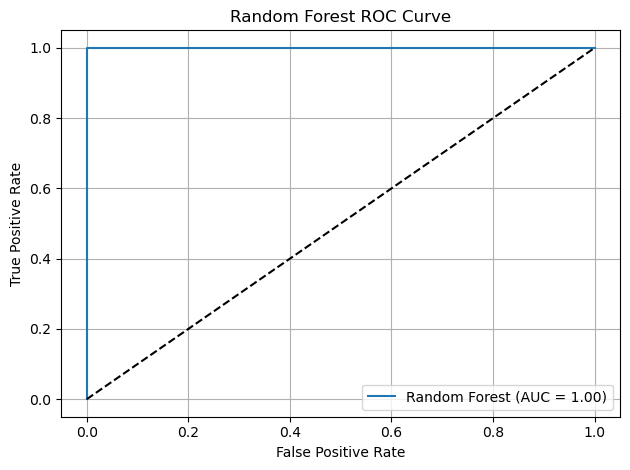

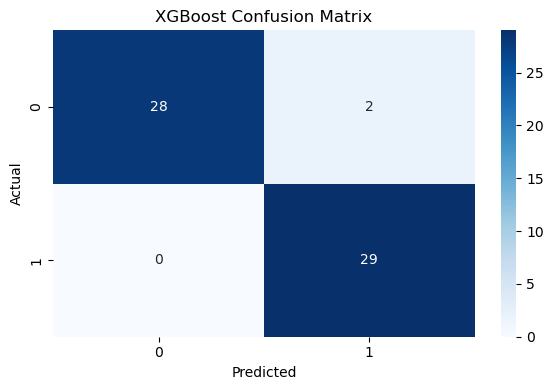

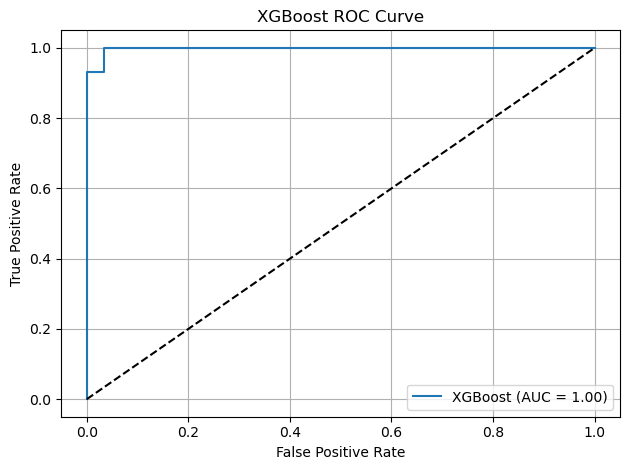

In [86]:
evaluate_model(grid_svm.best_estimator_, X_test, y_test, "SVM")
evaluate_model(grid_rf.best_estimator_, X_test, y_test, "Random Forest")
evaluate_model(grid_xgb.best_estimator_, X_test, y_test, "XGBoost")


## Model Comparison and Final Selection

In [94]:
# Create a results dictionary
results = {
    "Model": ["SVM", "Random Forest", "XGBoost"],
    "Best Parameters": [
        grid_svm.best_params_,
        grid_rf.best_params_,
        grid_xgb.best_params_
    ],
    "Best Score (CV)": [
        grid_svm.best_score_,
        grid_rf.best_score_,
        grid_xgb.best_score_
    ],
    "Test Accuracy": [
        accuracy_score(y_test, grid_svm.best_estimator_.predict(X_test)),
        accuracy_score(y_test, grid_rf.best_estimator_.predict(X_test)),
        accuracy_score(y_test, grid_xgb.best_estimator_.predict(X_test))
    ],
    "Test AUC": [
        roc_auc_score(y_test, grid_svm.best_estimator_.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, grid_rf.best_estimator_.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, grid_xgb.best_estimator_.predict_proba(X_test)[:, 1])
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("Model Performance Comparison:")
display(results_df.sort_values(by="Test AUC", ascending=False))
results_df.to_excel("best parameters.xlsx")


Model Performance Comparison:


,Model,Best Parameters,Best Score (CV),Test Accuracy,Test AUC
0,SVM,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.927660,1.000000,1.000000
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.957447,1.000000,1.000000
2,XGBoost,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",0.961702,0.966102,0.997701


## Select Best Model Based on AUC or Accuracy

In [148]:
best_model = grid_rf.best_estimator_
best_model

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

## Model Interpretation

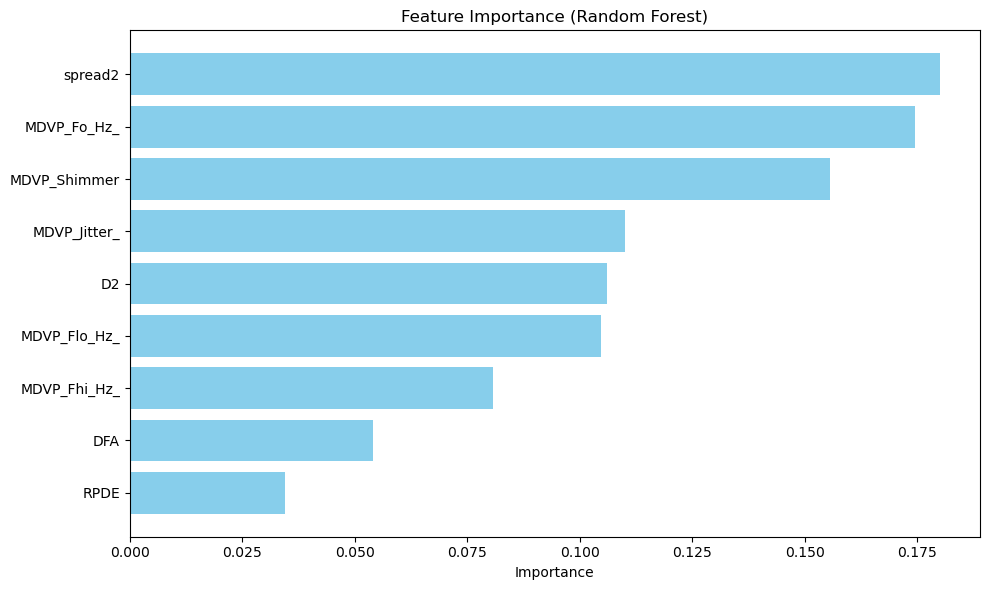

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Step 1: Use selected features from RFE
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Step 2: Fit Random Forest on selected features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_selected_df, y_resampled)

# Step 3: Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()

# Step 5: Save
plt.savefig('random_forest_feature_importance.png', dpi=300)
plt.show()

# Optional: Save the importance data as CSV
feature_importance_df.to_csv('random_forest_feature_importance.csv', index=False)


## Statistical Comparison Between Classifiers

#### Collect F1-scores for each classifier during cross-validation

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use X_selected and y_resampled
X_cv = pd.DataFrame(X_selected, columns=selected_features)
y_cv = y_resampled

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_cv_f1_scores(model, X, y):
    scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        scores.append(f1_score(y_test_fold, y_pred_fold))
    return scores

# F1-scores across folds
f1_svm = get_cv_f1_scores(grid_svm.best_estimator_, X_cv, y_cv)
f1_rf = get_cv_f1_scores(grid_rf.best_estimator_, X_cv, y_cv)
f1_xgb = get_cv_f1_scores(grid_xgb.best_estimator_, X_cv, y_cv)


In [102]:
f1_df = pd.DataFrame({
    'SVM': f1_svm,
    'Random Forest': f1_rf,
    'XGBoost': f1_xgb
})
print("F1-scores across folds:")
print(f1_df)


F1-scores across folds:
        SVM  Random Forest   XGBoost
0  0.931034       0.966667  0.949153
1  0.965517       0.949153  0.966667
2  0.945455       0.945455  0.925926
3  0.983051       0.966667  0.935484
4  0.964286       0.947368  0.982456


In [104]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
import numpy as np

# Differences
diff_svm_rf = f1_df['SVM'] - f1_df['Random Forest']
diff_svm_xgb = f1_df['SVM'] - f1_df['XGBoost']
diff_rf_xgb = f1_df['Random Forest'] - f1_df['XGBoost']

# Shapiro-Wilk Normality Tests
print("Shapiro-Wilk Test for Normality of Differences:")
for label, diff in zip(["SVM vs RF", "SVM vs XGB", "RF vs XGB"],
                       [diff_svm_rf, diff_svm_xgb, diff_rf_xgb]):
    stat, p = shapiro(diff)
    print(f"{label}: W = {stat:.4f}, p = {p:.4f} => {'Normal' if p > 0.05 else 'Not Normal'}")

# Decide which test to use based on normality
print("\nStatistical Test Results (Based on Normality):")

def compare_models(name, diff, model1, model2):
    if shapiro(diff).pvalue > 0.05:
        t, p = ttest_rel(model1, model2)
        print(f"{name}: Paired t-test → t = {t:.4f}, p = {p:.4f}")
    else:
        w, p = wilcoxon(model1, model2)
        print(f"{name}: Wilcoxon test → W = {w}, p = {p:.4f}")

compare_models("SVM vs Random Forest", diff_svm_rf, f1_df['SVM'], f1_df['Random Forest'])
compare_models("SVM vs XGBoost", diff_svm_xgb, f1_df['SVM'], f1_df['XGBoost'])
compare_models("Random Forest vs XGBoost", diff_rf_xgb, f1_df['Random Forest'], f1_df['XGBoost'])


Shapiro-Wilk Test for Normality of Differences:
SVM vs RF: W = 0.7365, p = 0.0222 => Not Normal
SVM vs XGB: W = 0.8906, p = 0.3599 => Normal
RF vs XGB: W = 0.8914, p = 0.3643 => Normal

Statistical Test Results (Based on Normality):
SVM vs Random Forest: Wilcoxon test → W = 4.0, p = 0.7150
SVM vs XGBoost: Paired t-test → t = 0.4743, p = 0.6600
Random Forest vs XGBoost: Paired t-test → t = 0.2490, p = 0.8156


In [106]:
from scipy.stats import ttest_rel

# Paired t-tests
t_svm_rf, p_svm_rf = ttest_rel(f1_df['SVM'], f1_df['Random Forest'])
t_svm_xgb, p_svm_xgb = ttest_rel(f1_df['SVM'], f1_df['XGBoost'])
t_rf_xgb, p_rf_xgb = ttest_rel(f1_df['Random Forest'], f1_df['XGBoost'])

# Display results
print("\nPaired t-test Results (F1-score comparison):")
print(f"SVM vs Random Forest:       t = {t_svm_rf:.4f}, p = {p_svm_rf:.4f}")
print(f"SVM vs XGBoost:             t = {t_svm_xgb:.4f}, p = {p_svm_xgb:.4f}")
print(f"Random Forest vs XGBoost:   t = {t_rf_xgb:.4f}, p = {p_rf_xgb:.4f}")



Paired t-test Results (F1-score comparison):
SVM vs Random Forest:       t = 0.2771, p = 0.7955
SVM vs XGBoost:             t = 0.4743, p = 0.6600
Random Forest vs XGBoost:   t = 0.2490, p = 0.8156


In [108]:
# Your paired t-test results
results = {
    "Comparison": [
        "SVM vs Random Forest",
        "SVM vs XGBoost",
        "Random Forest vs XGBoost"
    ],
    "t-statistic": [t_svm_rf, t_svm_xgb, t_rf_xgb],
    "p-value": [p_svm_rf, p_svm_xgb, p_rf_xgb]
}

results_df = pd.DataFrame(results)

# Save to Excel
results_df.to_excel("paired_ttest_results.xlsx", index=False)


### Comparative Summary Table & Discussion of Trade-offs

In [177]:
import pandas as pd

# Assume these values are your final evaluation metrics (replace with your actual results)
summary_data = {
    'Model': ['SVM', 'Random Forest', 'XGBoost'],
    'Accuracy': [1.00, 1.00, 0.97],
    'Precision': [1.00, 1.00, 0.94],
    'Recall': [1.00, 1.00, 1.00],
    'F1 Score': [1.00, 1.00, 0.97],
    'AUC': [1.00, 1.00, 1.00]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)


           Model  Accuracy  Precision  Recall  F1 Score  AUC
0            SVM      1.00       1.00     1.0      1.00  1.0
1  Random Forest      1.00       1.00     1.0      1.00  1.0
2        XGBoost      0.97       0.94     1.0      0.97  1.0


## Save the Best Model

In [182]:
import joblib

# Assuming best_model is the one you want to save, e.g. best_model = xgb_clf after tuning
filename = 'best_parkinson_model.joblib'

# Save model to disk
joblib.dump(best_model, filename)

print(f"Model saved to {filename}")


Model saved to best_parkinson_model.joblib


In [184]:
# Load model from disk
loaded_model = joblib.load(filename)

# Use loaded_model to predict on new data
# y_pred_new = loaded_model.predict(new_X)


In [186]:
import pickle

# Save
with open('best_parkinson_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Load
with open('best_parkinson_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
